In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import copy
from itertools import count
import warnings
warnings.filterwarnings("ignore")

In [4]:
!nvidia-smi

Sat Jan 28 19:02:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1

^C
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3130 sha256=0604cb4ff41f55e8bd483eaea2710732abab364a9bfe4c13939fa29ee75ffd76
  Stored in directory: /root/.cache/pip/wheels/e4/d2/e1/cc1c940178ad92438325422b51c3e8c3d927b9ef8381da8840
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=d53e236cfb6209bf5cd2ede39604664d620fec3e75f5869fdac3afd612cf21a9
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found ex

In [3]:
!pip install gym[Box2D]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 39.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [5]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("./DDPGlogs/")

In [6]:
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
TAU = 0.01

In [7]:
env = gym.make("LunarLanderContinuous-v2")
obs = env.reset()
episode_reward = 0.0

In [8]:
# Random noise generator: Taken from OpenAI baselines
class ActionNoise(object):
    def reset(self):
        pass

class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [9]:
std_dev = 0.2
ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=float(std_dev) * np.ones(1))

In [10]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [11]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)
    
    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32))
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, done, info = env.step(action)
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [12]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [13]:
# Policy/Actor Network
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x) * self.pmax
        torch.clip_(x, self.pmin, self.pmax)
        return x

    def __call__(self, x):
        out = self.forward(x)
        return out

In [14]:
#Critic Network
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.model(x)
        return x

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out

In [15]:
obs_size = env.observation_space.shape[0]
act_size = env.action_space.shape[0]
hiddenlayers = 128
output_minrange = env.action_space.low
output_maxrange = env.action_space.high

In [16]:
actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))
actor_target = copy.deepcopy(actor)
critic = DQN(obs_size + act_size, hiddenlayers)
critic_target = copy.deepcopy(critic)

In [17]:
actor_optimizer  = optim.AdamW(actor.parameters(), lr=0.0003)
critic_optimizer = optim.AdamW(critic.parameters(), lr=0.0003)

In [18]:
actor_loss_array = []
critic_loss_array = []
episode_reward_array = []

In [19]:
def update(episode):
        states, actions, rewards, dones, next_states = replay_memory.sample_batch()
        
        ou_noise.reset()
        # Critic loss  
        Qvals = critic(states, actions)
        with torch.no_grad():
            actions_ = actor_target(next_states)
            Qvals_ = critic_target(next_states, actions_)
            Qvals_[dones] = 0.0
            target = rewards + GAMMA * Qvals_
        critic_loss = F.smooth_l1_loss(target, Qvals)
        writer.add_scalar("Critic Loss", critic_loss, episode) 
        critic_loss_array.append(critic_loss)

        # Actor loss
        actor_loss = -critic(states, actor(states)).mean()
        writer.add_scalar("Actor Loss", actor_loss, episode)
        actor_loss_array.append(actor_loss)
        
        # update networks
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward() 
        critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(actor_target.parameters(), actor.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

        for target_param, param in zip(critic_target.parameters(), critic.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))


In [20]:
returns = deque(maxlen=50)

for episode in count():
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            action = actor(T(state)).numpy() + ou_noise()
        new_state, reward, done, _ = env.step(action) 
        transition = Transition(state, action, reward, done, new_state)
        replay_memory.append(transition)
        update(episode)         
        state = new_state
        episode_reward += reward
            
    returns.append(episode_reward)
    writer.add_scalar("Episode Reward", episode_reward, episode)
    episode_reward_array.append(episode_reward)
    score = np.mean(returns)
    if episode > 0 and episode % 50 == 0:
        print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
    if score >= 195:
        print(f'Solved! Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
        break

Episode: 50  Return: -139.52663384496276  Average Return: -81.4746105094708
Episode: 100  Return: -71.68378358825674  Average Return: -93.65667167496338
Episode: 150  Return: -58.878040688882145  Average Return: -68.64635012793585
Episode: 200  Return: 235.6675499788661  Average Return: 18.192526419736335
Episode: 250  Return: 229.45933346176065  Average Return: 84.90909478430734
Episode: 300  Return: -111.66482868778401  Average Return: 54.68207643486786
Episode: 350  Return: 153.96842242440414  Average Return: 86.2467199764892
Episode: 400  Return: 264.42630904931127  Average Return: 31.801385559696673
Episode: 450  Return: 30.45487744952004  Average Return: 180.8571980013149
Solved! Episode: 457  Return: 259.854457085558  Average Return: 195.14878735283403


# Results

In [ ]:
for i in range(len(actor_loss_array)):
  actor_loss_array[i] = actor_loss_array[i].detach().numpy()

for i in range(len(critic_loss_array)):
  critic_loss_array[i] = critic_loss_array[i].detach().numpy()

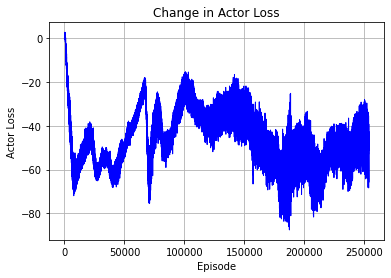

In [34]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Episode')
ax.set_ylabel('Actor Loss')
ax.set_title('Change in Actor Loss')
ax.plot(range(1, len(actor_loss_array) + 1), actor_loss_array, color='blue', linestyle='-', linewidth=1, label = "Actor Loss")
ax.grid()

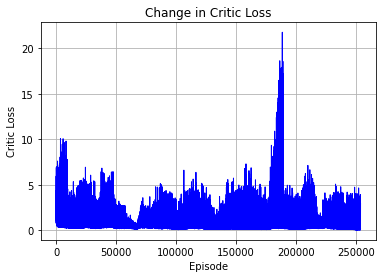

In [35]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Episode')
ax.set_ylabel('Critic Loss')
ax.set_title('Change in Critic Loss')
ax.plot(range(1, len(critic_loss_array) + 1), critic_loss_array, color='blue', linestyle='-', linewidth=1, label = "Critic Loss")
ax.grid()

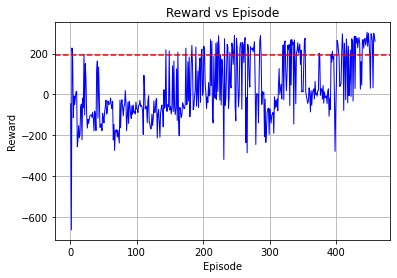

In [36]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Reward vs Episode')
ax.plot(range(1, len(episode_reward_array) + 1), episode_reward_array, color='blue', linestyle='-', linewidth=1, label = "Reward")
ax.axhline(y = 195, color = 'r', linestyle = '--')
ax.grid()

In [37]:
from colabgymrender.recorder import Recorder
env = Recorder(env, './video')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4104192/45929032 bytes (8.9%)8495104/45929032 bytes (18.5%)12754944/45929032 bytes (27.8%)17145856/45929032 bytes (37.3%)21241856/45929032 bytes (46.2%)25649152/45929032 bytes (55.8%)30007296/45929032 bytes (65.3%)34242560/45929032 bytes (74.6%)38576128/45929032 bytes (84.0%)42786816/45929032 bytes (93.2%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


In [38]:
state = env.reset()
done = False
while not done:
    with torch.no_grad():
        action = actor(T(state)).numpy()
        next_state, reward, done, _ = env.step(action)
        state = next_state     
env.play()